In [1]:
import os

import torch
from torch import nn
from data.data import *
from models.AudioResnet import AudioResnet
from loss.FocalLoss import FocalLoss

augmentations = Compose([
    AddGaussianNoise(std=0.5),
    TimeMasking(max_mask_pct=0.15),
    FrequencyMasking(max_mask_pct=0.15),
])

class Config:
    # === General ===

    model_name = "CNN-NEST-BIGGER-TOP-50-LIBROSA-Augment-MEDIUM"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dtype = torch.float32
    save_path = f"trained_models\\{model_name}\\"
    seed = 42

    # === Training ===
    num_classes = 50
    num_epochs = 100
    batch_size = 1
    max_batch_size = 64
    learning_rate = 5e-5
    min_learning_rate = 1e-4
    weight_decay = 1e-4

    warmup_threshold = 1.0 / 100.0
    step_coefficient = 25.0 / 100.0

    gamma = 2.0
    save_checkpoints = True

    # === Dataset ===
    transforms = None
    use_masks = True
    num_workers = 1
    prefetch_factor = 3
    val_split = 0.1
    shuffle = True
    pos_weight = (torch.ones(num_classes) * 10).to("cuda")
    criterion = FocalLoss(gamma=0.0, reduction='mean', pos_weight=pos_weight)

In [ ]:
from data.processing import ParseBalanced

directory = "large-melspec-dataset-top-50-LIBROSA"
data_directory = "E:/mtg-jamendo/"
subset_file_name = "autotagging_top50tags"
ParseBalanced(subset_file_name, f"{data_directory}", f"E:/SongsDataset/{directory}", convert=True, target_per_genre=1300)

In [2]:
from torch.utils.data import DataLoader

large_directory = "large-melspec-dataset-top-50-LIBROSA"

train_dataset = StreamingSongDataset(f"E:\\SongsDataset\\{large_directory}\\train_set\\data", f"E:\\SongsDataset\\{large_directory}\\train_set\\genre_labels", transform=augmentations)
test_dataset = StreamingSongDataset(f"E:\\SongsDataset\\{large_directory}\\test_set\\data", f"E:\\SongsDataset\\{large_directory}\\test_set\\genre_labels")

train_dataloader = DataLoader(
    train_dataset,
    batch_size=Config.batch_size,
    shuffle=True,
    num_workers=Config.num_workers,
    prefetch_factor=Config.prefetch_factor,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=Config.batch_size,
    shuffle=True,
    num_workers=Config.num_workers,
    prefetch_factor=Config.prefetch_factor,
)

In [ ]:
from models.ShortChunkCNN import ShortChunkCNN
from utils import misc

model = AudioResnet(num_classes=50)
print(f"{misc.model_size(model)} Parameters")

In [3]:
from vit_pytorch.nest import NesT
from utils import misc

model = NesT(
    image_size = 256,
    patch_size = 8,
    dim = 256,
    heads = 4,
    num_hierarchies = 4,        # number of hierarchies
    block_repeats = (2, 3, 4, 5),  # the number of transformer blocks at each hierarchy, starting from the bottom
    num_classes = 50,
    channels = 1
)

print(f"{misc.model_size(model)} Parameters")

338071026 Parameters


In [3]:
from models.NESTCNN import NESTCNN
from utils import misc

model = NESTCNN(
    image_size = 256,
    patch_size = 8,
    dim = 256,
    cnn_initial_channels_dim = 32,
    heads = 4,
    num_hierarchies = 3,        # number of hierarchies
    block_repeats = (2, 3, 4),  # the number of transformer blocks at each hierarchy, starting from the bottom
    num_classes = 50,
    channels = 1
)

print(f"{misc.model_size(model)} Parameters")

67933170 Parameters


In [ ]:
from training.classification_training import train_classifier
train_classifier(model, test_dataloader, train_dataloader, Config, show_graph=True)

In [ ]:
from training.classification_training import evaluate_classification
from utils.visualization import visualize_ROC_PR_AUC

def lav(file):
    model = torch.load(file, weights_only=False)

    test_loss_average, all_probs, all_labels = evaluate_classification(model, test_dataloader, Config)

    all_p_tensor = torch.stack([torch.tensor(x) for x in all_probs], dim=0).float()
    all_l_tensor = torch.stack([torch.tensor(x) for x in all_labels], dim=0).int()

    visualize_ROC_PR_AUC(all_p_tensor, all_l_tensor)
    print(f"Loss: {test_loss_average:04}")

for f in sorted(os.listdir("E:/Coding/SongAnalyzer/Analyzer/src/trained_models/NesT-TOP-50-LIBROSA-Augment-MEDIUM/"))[23:31]:
    file = "E:/Coding/SongAnalyzer/Analyzer/src/trained_models/NesT-TOP-50-LIBROSA-Augment-MEDIUM/" + f
    lav(file)

In [11]:
from data.processing import ReadStats

subset_file_name = "autotagging_top50tags"
tag_mapping = ReadStats(subset_file_name)
reversed_tag_mapping = {v: k for k, v in tag_mapping.items()}

In [7]:
model = torch.load("E:/Coding/SongAnalyzer/Analyzer/src/trained_models/CNN-NEST-TOP-50-LIBROSA-Augment-MEDIUM/Classifier-Epoch-29.pt", weights_only=False)

In [8]:
from training.classification_training import evaluate_classification

test_loss_average, all_probs, all_labels = evaluate_classification(model, test_dataloader, Config)

all_p_tensor = torch.stack([torch.tensor(x) for x in all_probs], dim=0).float()
all_l_tensor = torch.stack([torch.tensor(x) for x in all_labels], dim=0).int()

  0%|          | 0/11 [00:00<?, ?it/s]

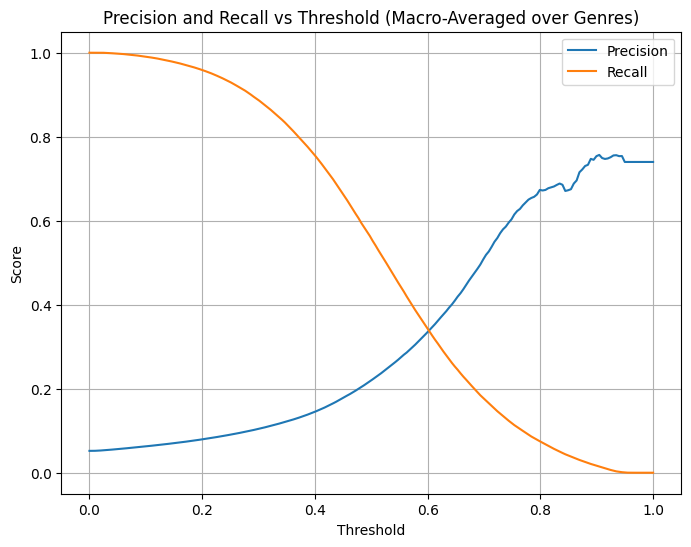

ROC-AUC: 0.8199	PR-AUC: 0.3041


In [9]:
from utils.visualization import visualize_ROC_PR_AUC

visualize_ROC_PR_AUC(all_p_tensor, all_l_tensor)

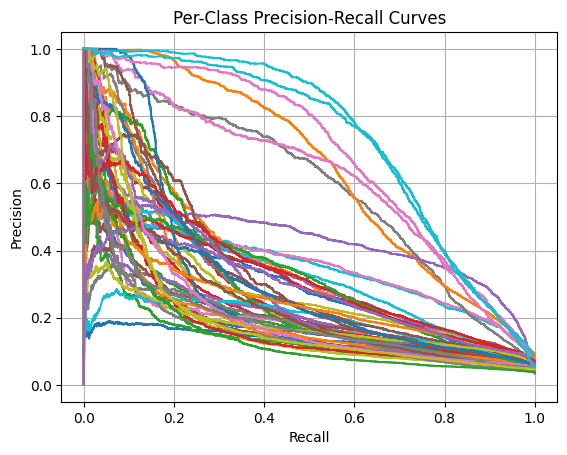

AP per class:

electronic          : 0.196
soundtrack          : 0.363
pop                 : 0.221
piano               : 0.278
ambient             : 0.323
synthesizer         : 0.169
rock                : 0.217
drums               : 0.301
bass                : 0.265
classical           : 0.364
easylistening       : 0.137
guitar              : 0.246
electricguitar      : 0.295
experimental        : 0.251
alternative         : 0.217
chillout            : 0.205
dance               : 0.363
hiphop              : 0.591
indie               : 0.292
folk                : 0.315
orchestral          : 0.294
jazz                : 0.644
lounge              : 0.150
newage              : 0.309
techno              : 0.436
poprock             : 0.314
house               : 0.623
computer            : 0.151
keyboard            : 0.195
acousticguitar      : 0.192
world               : 0.283
violin              : 0.193
popfolk             : 0.314
drummachine         : 0.193
happy               : 0.268
voice

In [12]:
from matplotlib import pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_curve

for i in range(50):
    precision, recall, thresholds = precision_recall_curve(all_l_tensor[:, i], all_p_tensor[:, i])
    ap = average_precision_score(all_l_tensor[:, i], all_p_tensor[:, i])
    plt.plot(recall, precision, label=f"Class {i} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
#plt.legend()
plt.title("Per-Class Precision-Recall Curves")
plt.grid(True)
plt.show()

ap_per_class = [average_precision_score(all_l_tensor[:, i], all_p_tensor[:, i]) for i in range(50)]
print(f"AP per class:\n")
for index in range(len(ap_per_class)):
    print(f"{reversed_tag_mapping[index]:<20}: {ap_per_class[index]:.03f}")

In [ ]:
for tag in tag_mapping.keys():
    index = tag_mapping[tag]
    print(f"Tag: {tag}\nAP: {ap_per_class[index]}\n\n")

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

def compute_full_multilabel_confusion_matrix(preds, targets, threshold=0.5):
    preds = np.array(preds)
    targets = np.array(targets)

    # Binarize predictions
    preds = (preds >= threshold).astype(int)

    return multilabel_confusion_matrix(targets, preds)

In [ ]:
conf_matrix = compute_full_multilabel_confusion_matrix(all_p_tensor, all_l_tensor)
for i, cm in enumerate(conf_matrix):
    print(f"Class {i}:\n[[TN: {cm[0,0]}  FP: {cm[0,1]}]\n [FN: {cm[1,0]}  TP: {cm[1,1]}]]\n")

In [13]:
from training.inference import inference_on_directory

directory = "E:/SongsDataset/songs"
df = inference_on_directory(subset_file_name, directory, Config, model, num_songs=30, aggregation='mean')

Reading: 54380 tracks, 11107 albums, 3517 artists


100%|██████████| 30/30 [00:37<00:00,  1.24s/it]


Confidence Scores for Piano- City Ruins


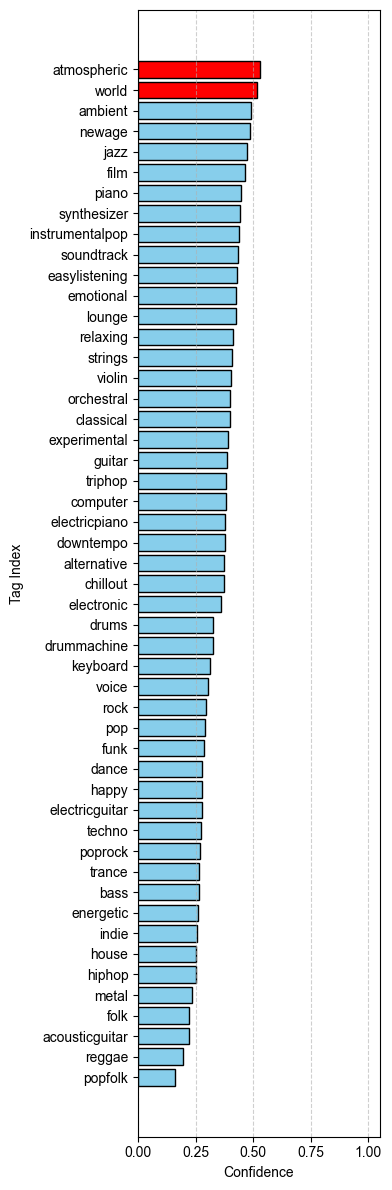

Confidence Scores for Get Lucky (feat. Pharrell Williams and Nile Rodgers)


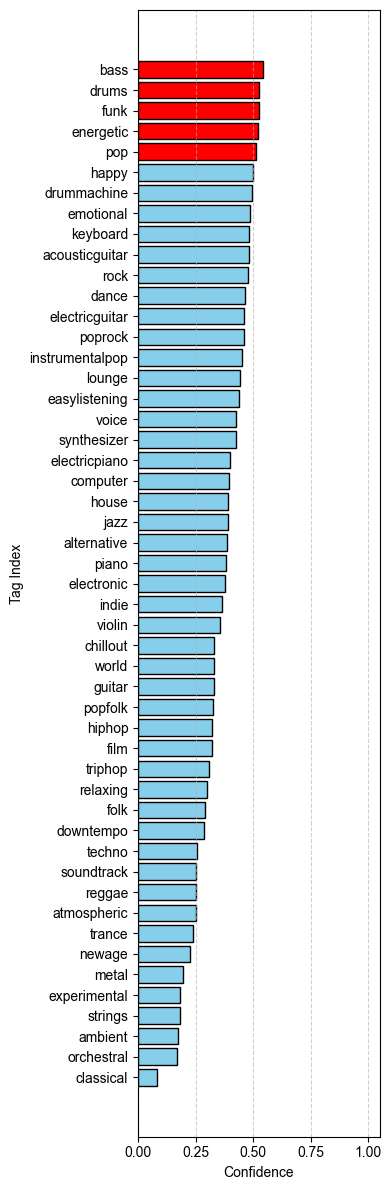

Confidence Scores for Change The Formality


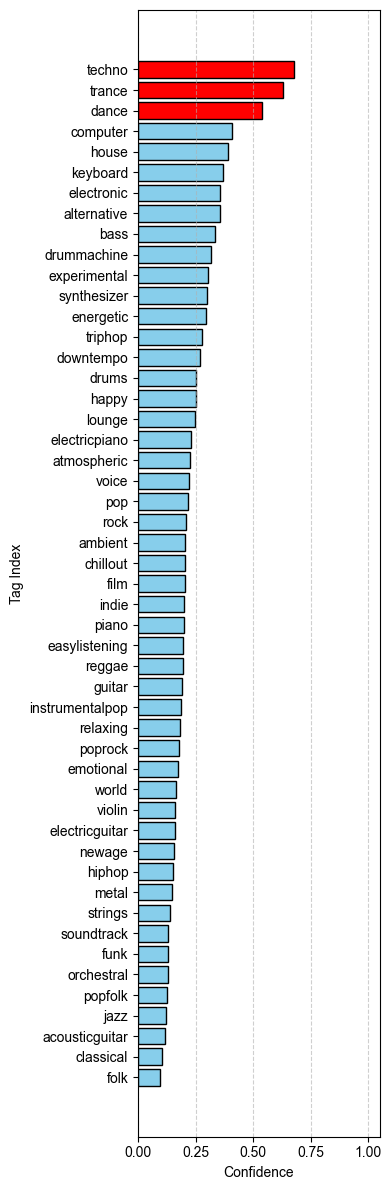

Confidence Scores for Gotta Go Fast (Sonic X Theme)


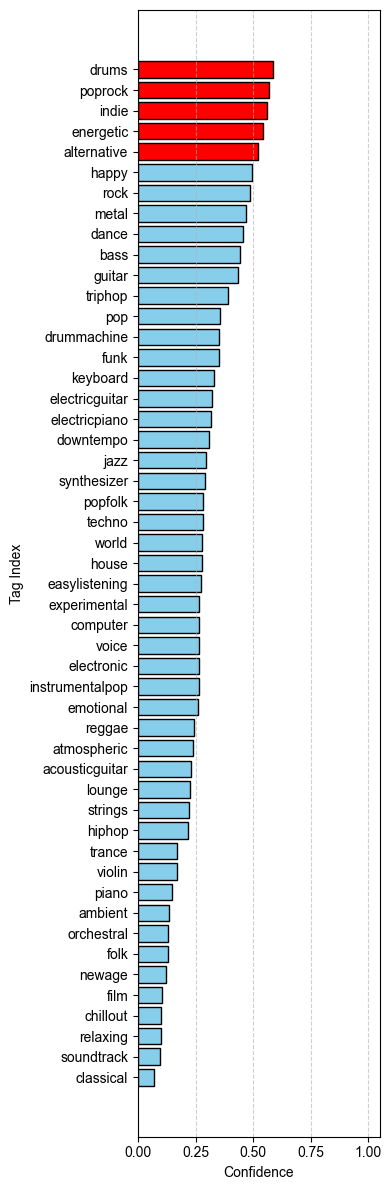

Confidence Scores for BLOOD X


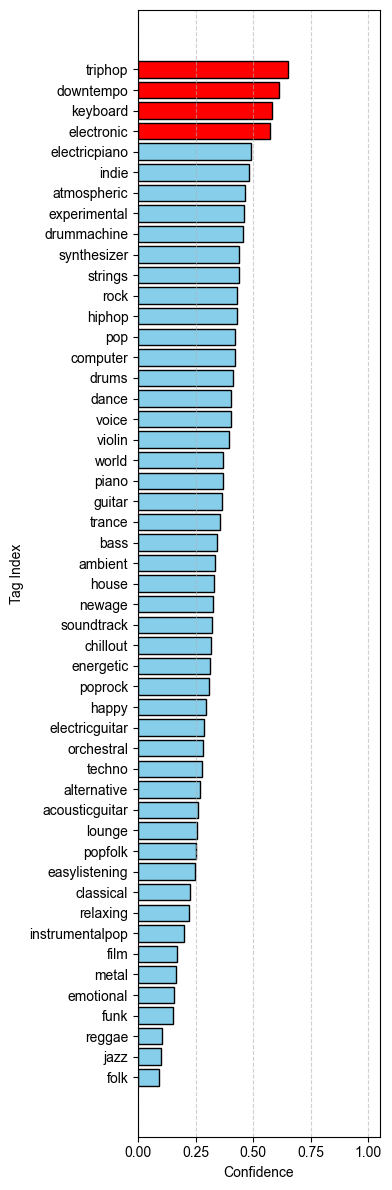

Confidence Scores for Ghibli


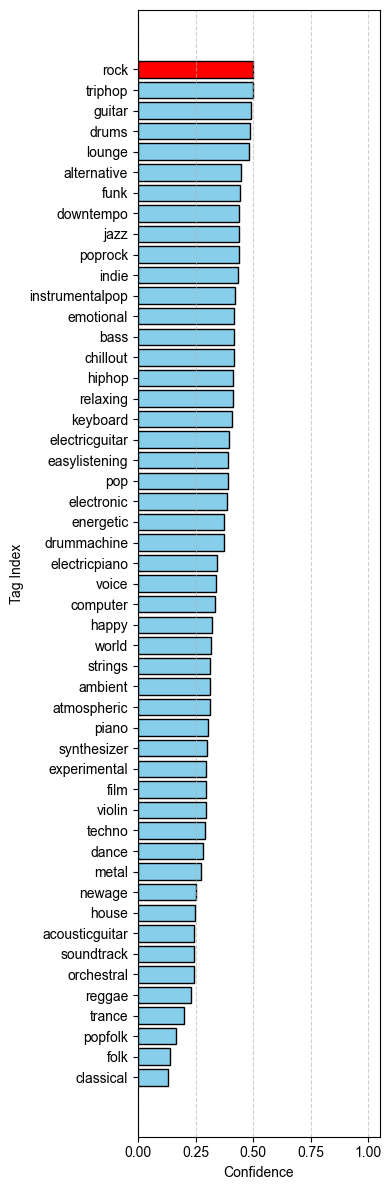

Confidence Scores for 眠れない


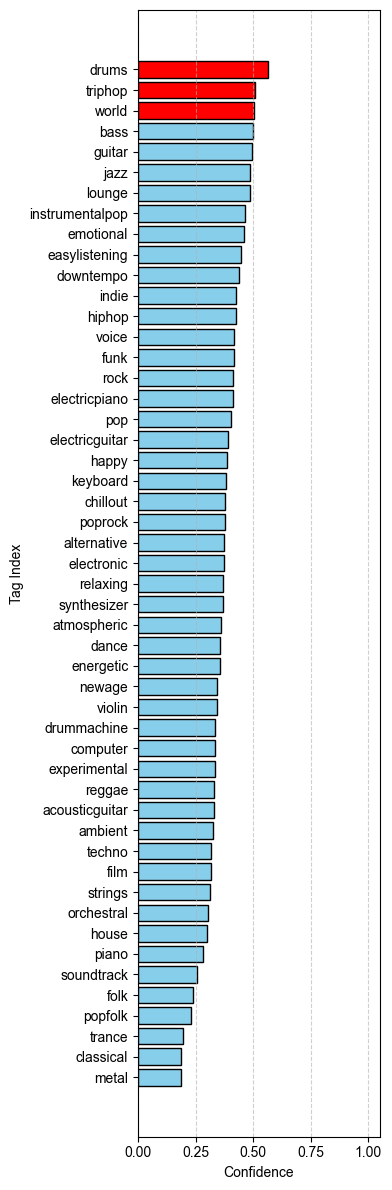

Confidence Scores for 我亲爱傀儡


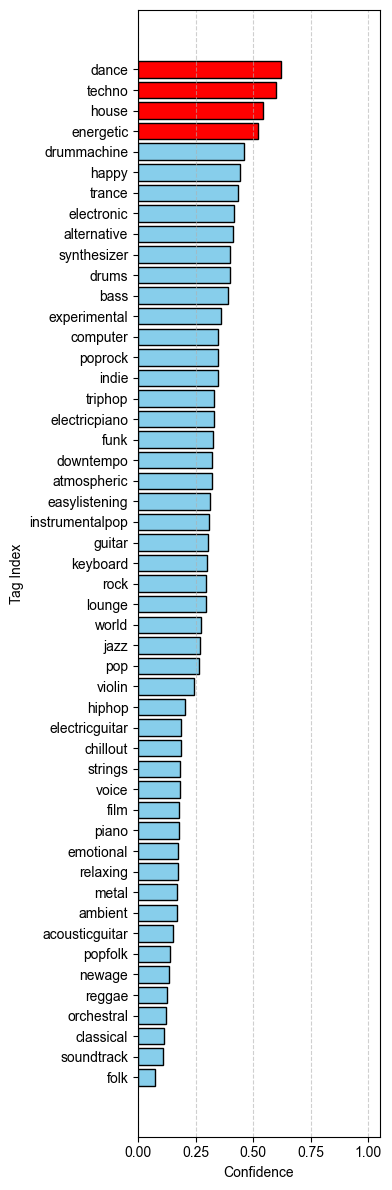

Confidence Scores for 1AM (From 'Animal Crossing- New Leaf')


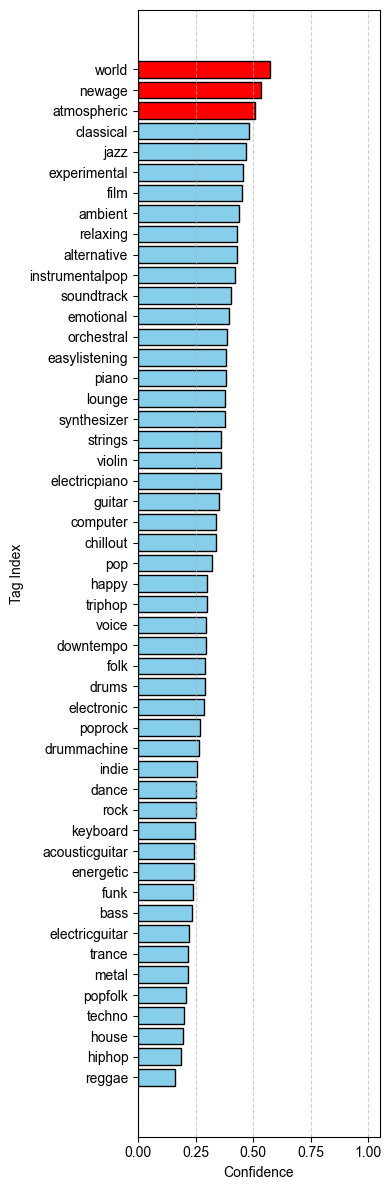

Confidence Scores for Look In The Window


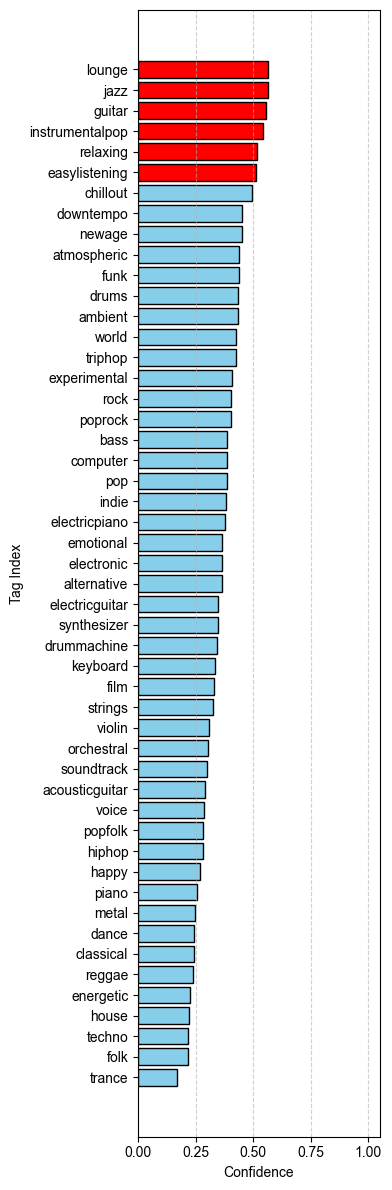

Confidence Scores for Pika Girl


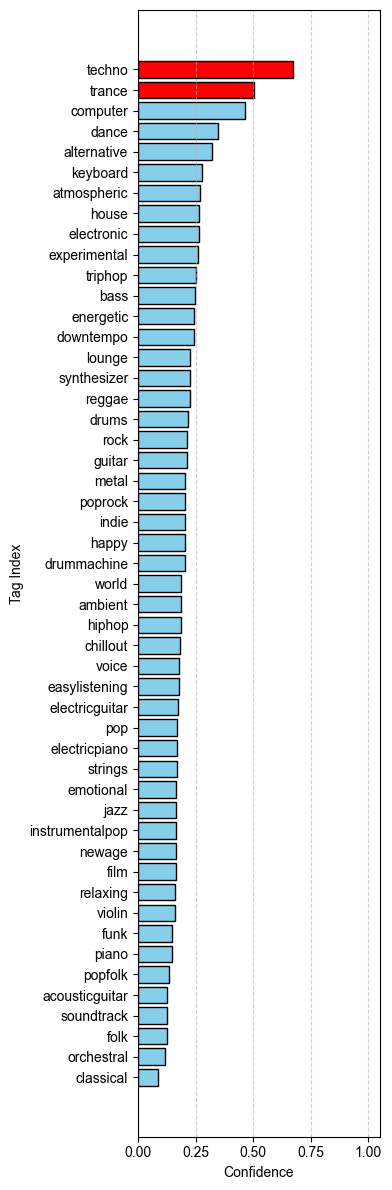

Confidence Scores for 名探偵コナン メイン・テーマ


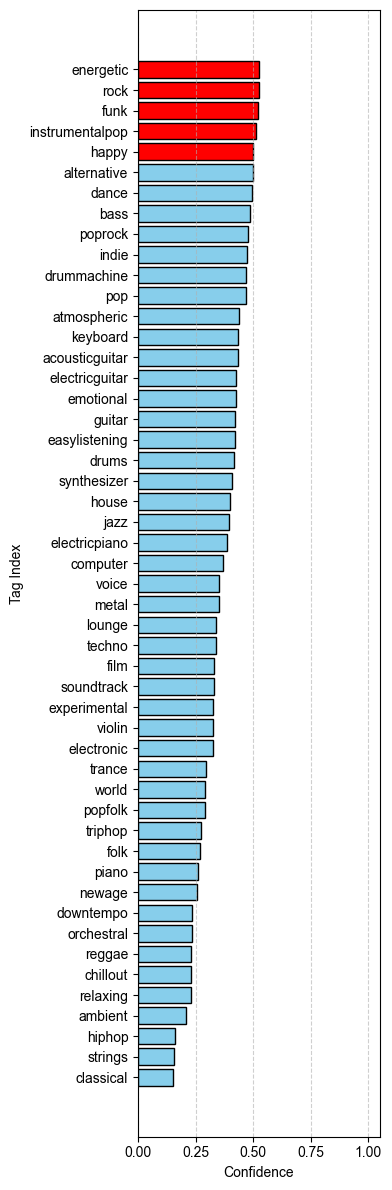

Confidence Scores for Moonlight


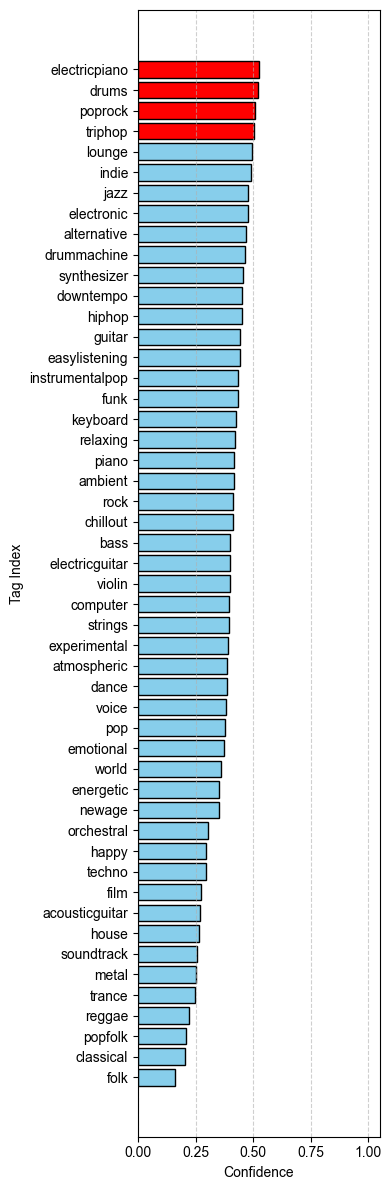

Confidence Scores for at That Place


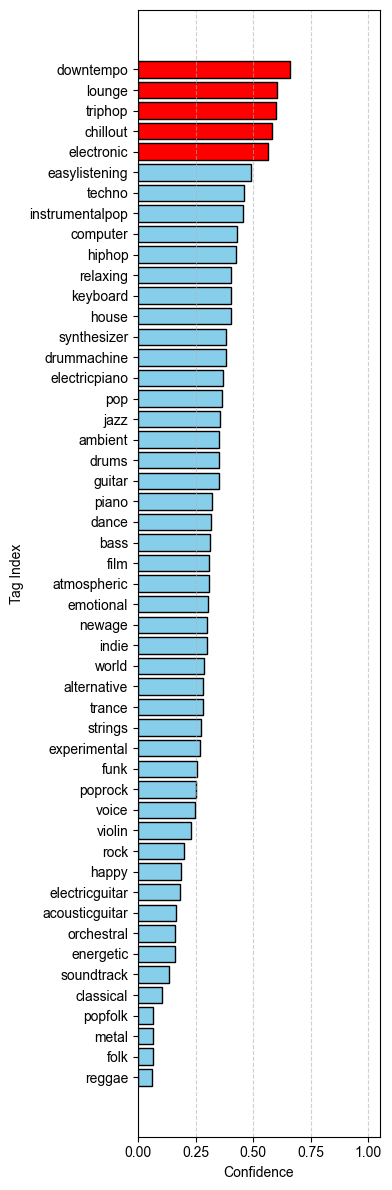

Confidence Scores for Snow-Sleep


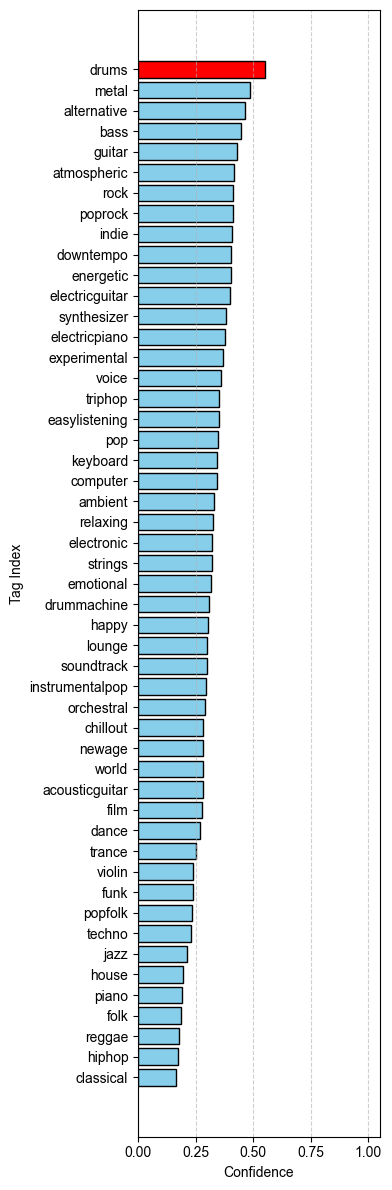

Confidence Scores for The Intrepid


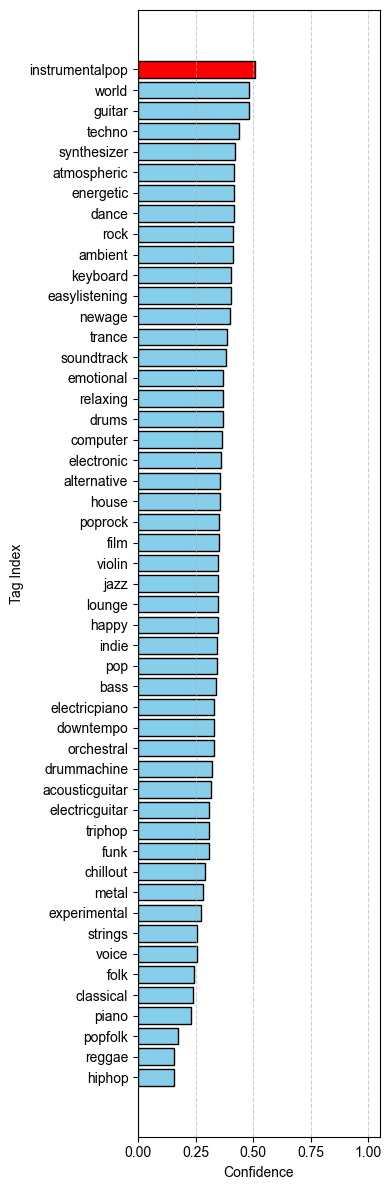

Confidence Scores for Smile Fight


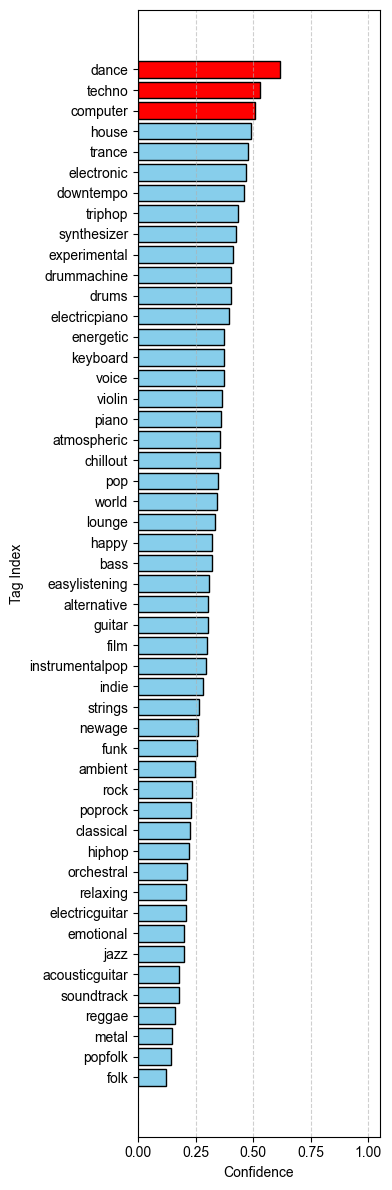

Confidence Scores for I don't care about Christmas though


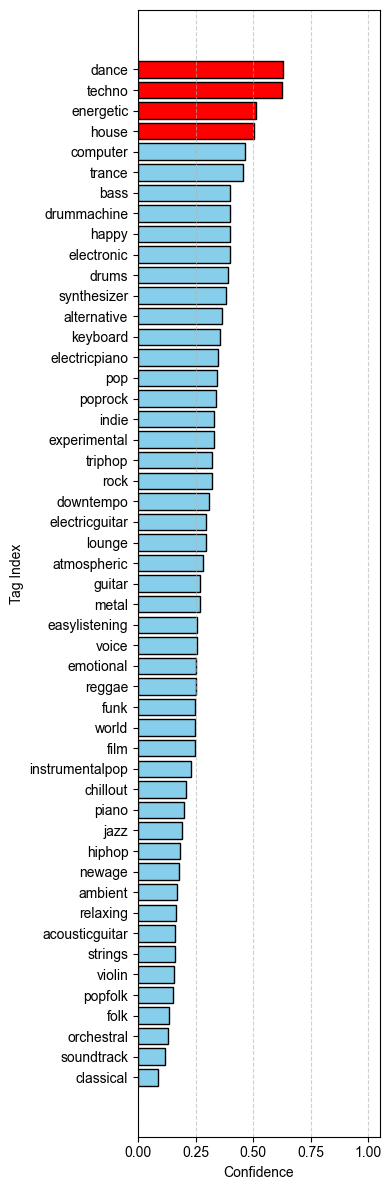

Confidence Scores for Miracle Groovin'


KeyboardInterrupt: 

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Specify prediction and actual tag columns
pred_cols = [f'Confidence {reversed_tag_mapping[i]}' for i in range(50)]
actual_cols = [f'Tag {reversed_tag_mapping[i]}' for i in range(50)]

# Plot one graph per row
for idx, row in df.iterrows():
    track_id = row['Track ID']
    confidences = row[pred_cols].values.astype(float)
    actuals = row[actual_cols].values.astype(int)
    tag_names = [reversed_tag_mapping[i] for i in range(50)]

    # Sort by confidence (highest first)
    sort_idx = np.argsort(confidences)
    confidences = confidences[sort_idx]
    actuals = actuals[sort_idx]
    tag_names = [tag_names[i] for i in sort_idx]

    x = np.arange(len(confidences))  # tag indices 0..49

    # Plot confidence values as bars
    plt.figure(figsize=(4, 12))

    bar_colors = ['red' if conf > 0.5 else 'skyblue' for conf in confidences]

    bars = plt.barh(x, confidences, color=bar_colors, edgecolor='black')

    # Highlight actual labels where ground truth == 1
    for i, actual in enumerate(actuals):
        if actual == 1:
            bars[i].set_color('purple')
            bars[i].set_edgecolor('white')

    # Optional: Mark actual label positions with a star
    for i, actual in enumerate(actuals):
        if actual == 1:
            plt.plot(i, confidences[i] + 0.1, '*', markersize=10)

    plt.yticks(ticks=x, labels=tag_names)
    # Using this font family as they support kana
    print(f'Confidence Scores for {track_id}')
    plt.rcParams["font.family"] = "Arial"
    plt.ylabel('Tag Index')
    plt.xlabel('Confidence')
    plt.xlim(0, 1.05)
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [ ]:
from torchcam.methods import GradCAM
cam_extractor = GradCAM(model, target_layer="layer4")

In [ ]:
def toMEL(wv, sr):
    spec = librosa.feature.melspectrogram(y=wv, sr=sr)
    spec = librosa.amplitude_to_db(spec, ref=np.max)
    return spec

def process_song(song_path, folder_in, folder_out, transform):
    latents_path_name = os.path.join(folder_out, song_path[:-4] + ".npy")

    if os.path.exists(latents_path_name):
        return

    try:
        wv, sr = librosa.load(os.path.join(folder_in, song_path), sr=44100)
        latent_space = transform(wv, sr)
        np.save(latents_path_name, latent_space)
    except Exception as e:
        print(f"Error processing {song_path}: {e}")

def encodeFolder(folder_in, folder_out, transform, num_threads=8):
    os.makedirs(folder_out, exist_ok=True)
    song_paths = os.listdir(folder_in)

    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = [
            executor.submit(process_song, song_path, folder_in, folder_out, transform)
            for song_path in song_paths
        ]
        for _ in tqdm(as_completed(futures), total=len(futures), desc=f"Processing {folder_in}"):
            pass

# Run for folders 50 to 98
for index in range(0, 99):
    folder_name = f"E:/mtg-jamendo/{index:02}"
    encodeFolder(folder_name, "E:/SongsDataset/MELSPEC/", toMEL)